In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras as ks

In [4]:
from tensorflow.estimator import LinearRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

print(tf.__version__)

2.4.1


In [52]:
# lets look at alll the datsets we can load
for i in datasets.__dict__:
  if ('load' in str(i)):
    print(i)

__loader__
load_breast_cancer
load_boston
load_diabetes
load_digits
load_files
load_iris
load_linnerud
load_sample_images
load_sample_image
load_wine
load_svmlight_file
load_svmlight_files


In [54]:
diabetes_load = datasets.load_diabetes()

In [56]:
diabetes_load.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [57]:
feature_columns = diabetes_load.feature_names

In [59]:
diabetes_load.target[:5]

array([151.,  75., 141., 206., 135.])

In [60]:
target_column = diabetes_load.target

In [61]:
diabetes_load = pd.DataFrame(diabetes_load.data, columns=feature_columns).astype(np.float32)

In [62]:
diabetes_load.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [65]:
diabetes_load['TARG'] = target_column.astype(np.float32)
diabetes_load.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,TARG
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


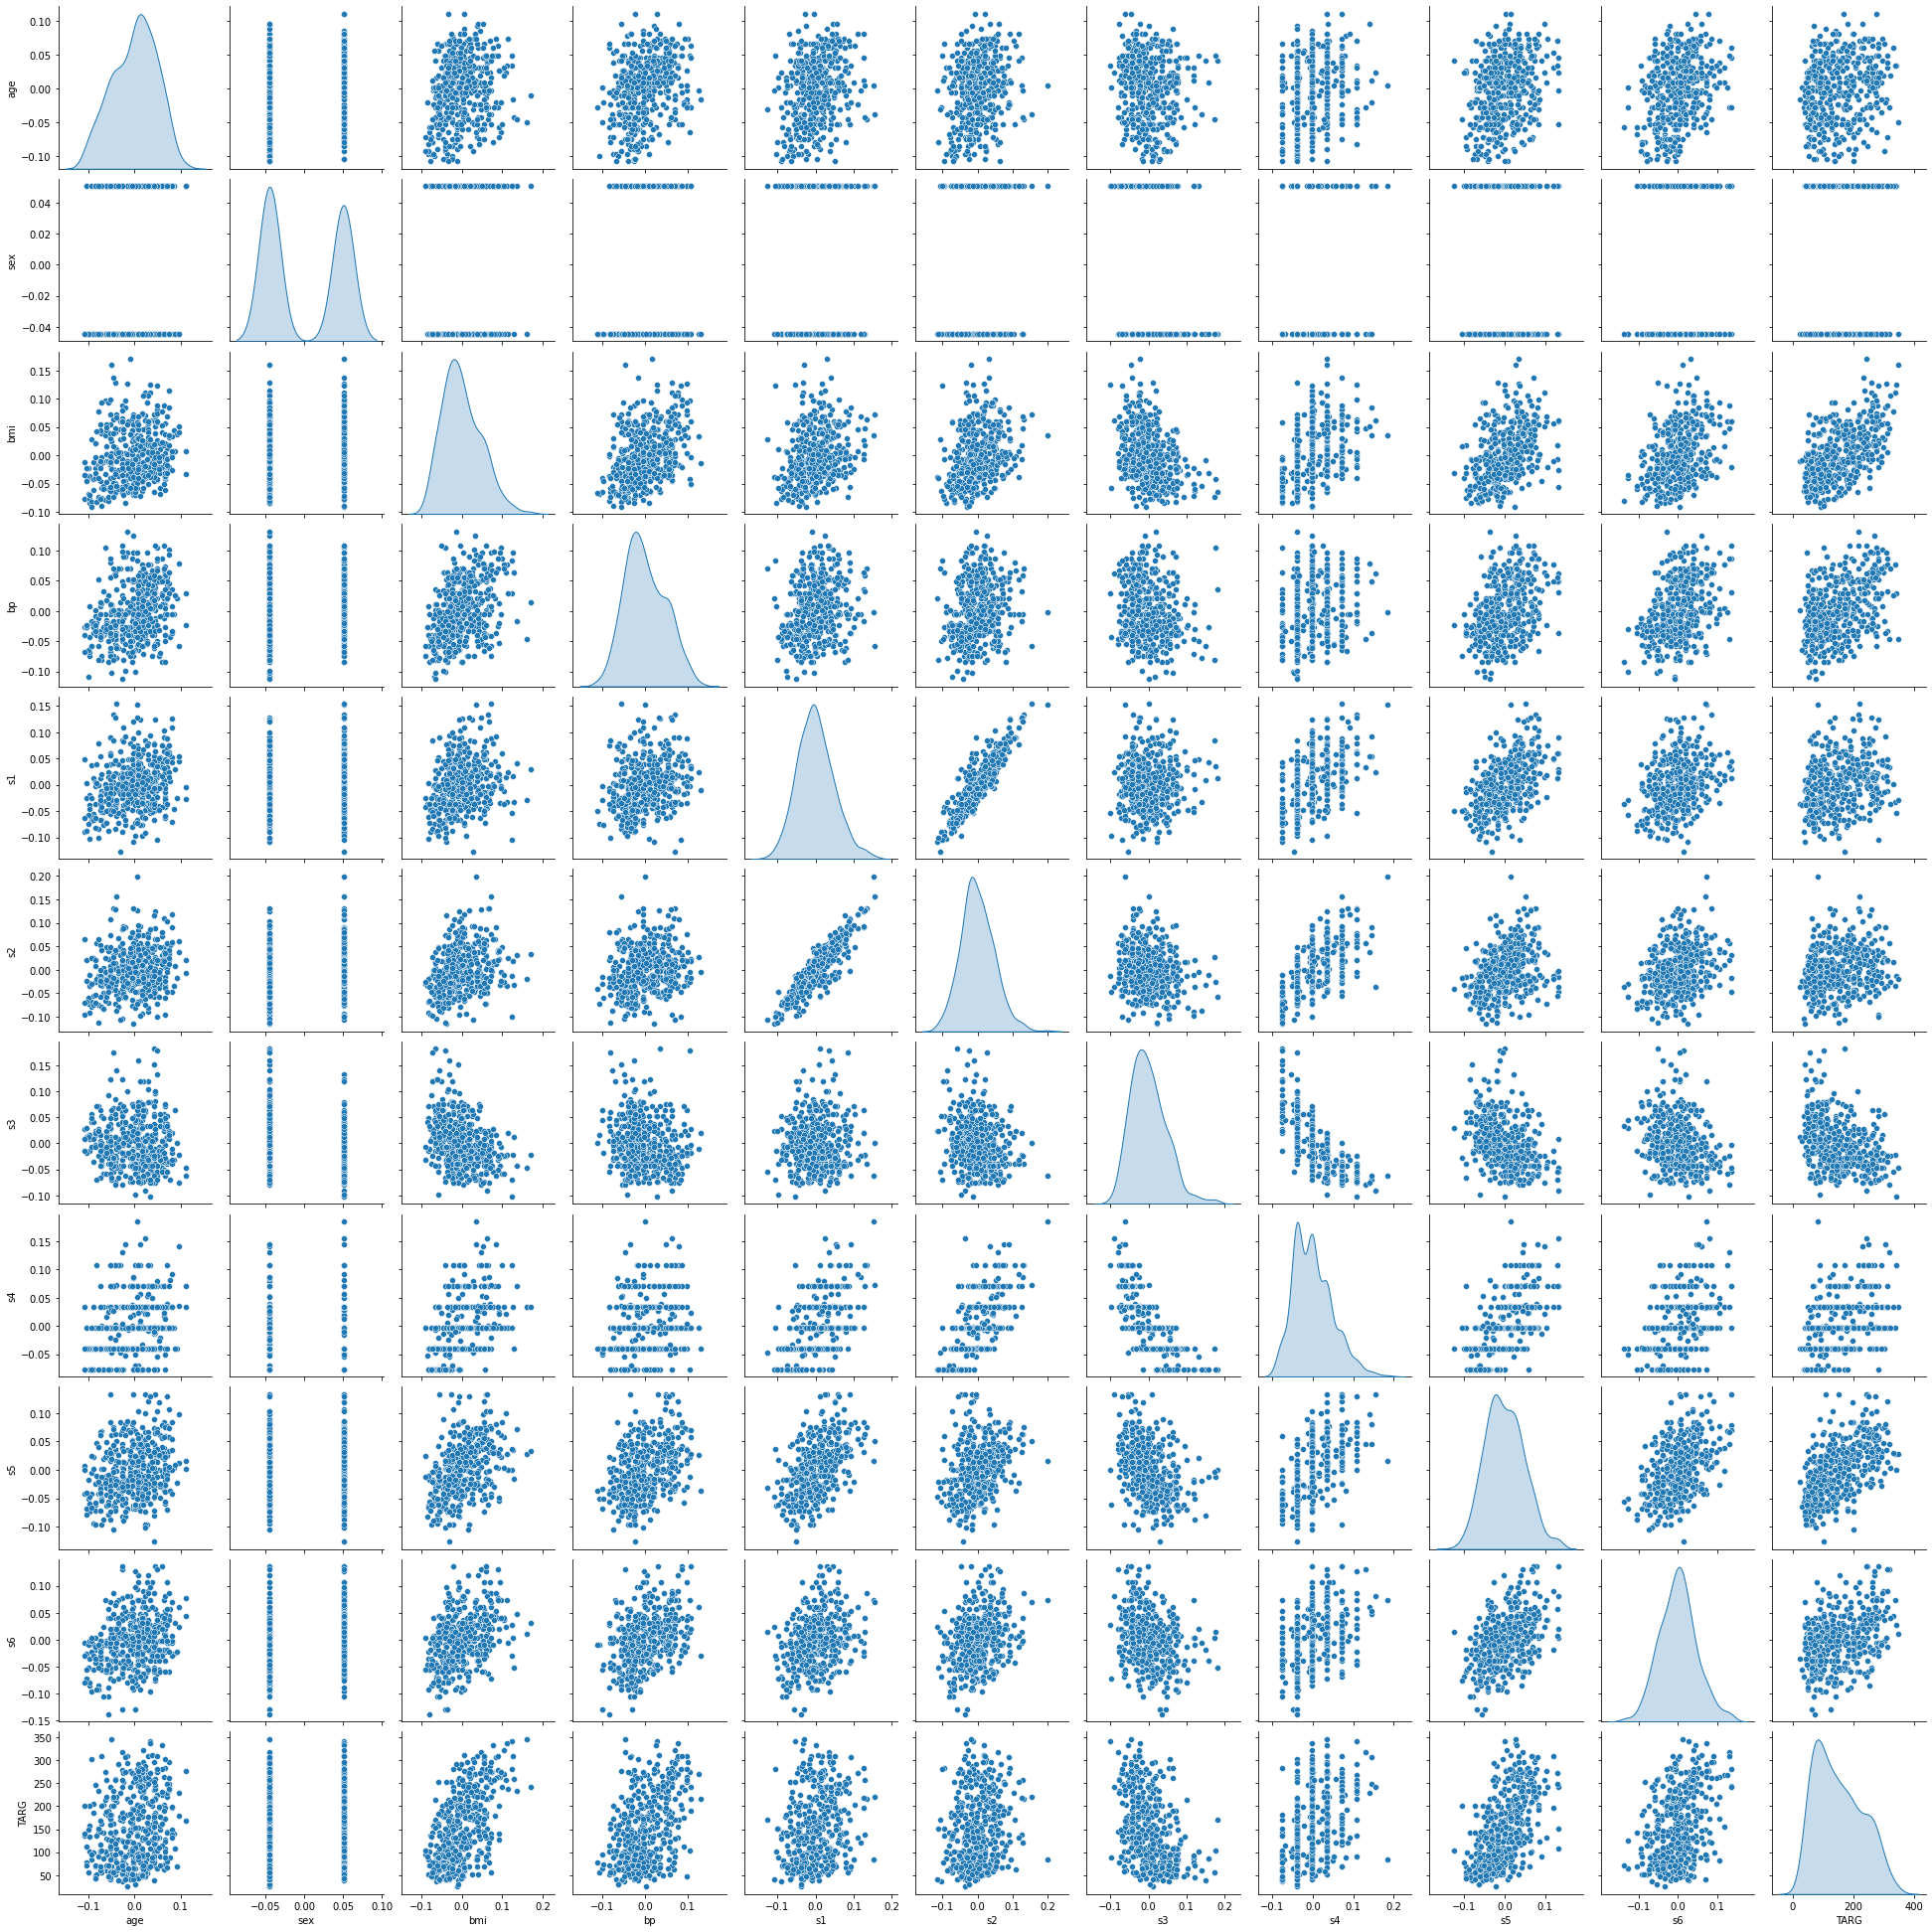

In [66]:
sb.pairplot(diabetes_load, diag_kind="kde")

In [67]:
correlation_data = diabetes_load.corr()
correlation_data.style.background_gradient(cmap='coolwarm', axis=None)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,TARG
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


In [68]:
stats = diabetes_load.describe()
diabetes_stats = stats.transpose()
diabetes_stats

,count,mean,std,min,25%,50%,75%,max
age,442.0,2.191347e-10,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,7.079737e-10,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-5.899781e-10,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-5.562651e-10,0.047619,-0.112400,-0.036656,-0.005671,0.035644,0.132044
s1,442.0,1.061961e-09,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,-1.057746e-09,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,4.045564e-10,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,2.477908e-09,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.271084e-10,0.047619,-0.126097,-0.033249,-0.001948,0.032433,0.133599
s6,442.0,-2.809771e-09,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


In [72]:
X_data = diabetes_load[[i for i in diabetes_load.columns if i not in ['TARG']]]
Y_data = diabetes_load[['TARG']]

In [73]:
training_features, test_features, training_labels, test_labels = train_test_split(X_data, Y_data, test_size=0.2)

In [74]:
print(test_features.shape)
print(training_features.shape)
print(training_labels.shape)
print(test_labels.shape)

(89, 10)
(353, 10)
(353, 1)
(89, 1)


In [76]:
# normalise the data
def norm(x):
  stats = x.describe()
  stats = stats.transpose()
  return (x-stats['mean']) / stats['std']

In [77]:
normed_train_features = norm(training_features)
normed_test_features = norm(test_features)

In [78]:
# shuffling and creating a batch
def feed_input(features_dataframe, target_dataframe, num_of_epochs=10, shuffle=True, batch_size=32):
  def input_feed_function():
    dataset = tf.data.Dataset.from_tensor_slices((dict(features_dataframe), target_dataframe))
    if shuffle:
      dataset = dataset.shuffle(2000)
    dataset = dataset.batch(batch_size).repeat(num_of_epochs)
    return dataset
  return input_feed_function

In [79]:
train_feed_input = feed_input(normed_train_features, training_labels)
train_feed_input_testing = feed_input(normed_train_features, training_labels, num_of_epochs=1, shuffle=False)

In [91]:
train_feed_input()

<RepeatDataset shapes: ({age: (None,), sex: (None,), bmi: (None,), bp: (None,), s1: (None,), s2: (None,), s3: (None,), s4: (None,), s5: (None,), s6: (None,)}, (None, 1)), types: ({age: tf.float64, sex: tf.float64, bmi: tf.float64, bp: tf.float64, s1: tf.float64, s2: tf.float64, s3: tf.float64, s4: tf.float64, s5: tf.float64, s6: tf.float64}, tf.float32)>

In [80]:
test_feed_input = feed_input(normed_test_features, test_labels, num_of_epochs=1, shuffle=False)

In [92]:
feature_columns_numeric = [tf.feature_column.numeric_column(m) for m in training_features.columns]

feature_columns_numeric

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sex', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='bmi', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='bp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='s1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='s2', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='s3', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='s4', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='s5', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='s6', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [93]:
linear_model = LinearRegressor(feature_columns=feature_columns_numeric, optimizer='RMSProp')

linear_model.train(train_feed_input)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp2xql0ft3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp2xql0ft3/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 35683.812, step = 0
INFO:tensorflow:global_step/sec: 433.08
INFO:tensorflow:loss = 20932.969, step = 100 (0.234 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120...
INFO:tensorflow:Saving checkpoints for 120 into /tmp/tmp2xql0ft3/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120...
INFO:tensorflow:Loss for final step: 3502.0195.


In [97]:
linear_model.__dict__

{'_config': <tensorflow_estimator.python.estimator.run_config.RunConfig at 0x7fb99eb3cb90>,
 '_device_fn': None,
 '_eval_distribution': None,
 '_model_dir': '/tmp/tmp2xql0ft3',
 '_model_fn': <function tensorflow_estimator.python.estimator.canned.linear.LinearRegressorV2.__init__.<locals>._model_fn>,
 '_params': {},
 '_session_config': allow_soft_placement: true
 graph_options {
   rewrite_options {
     meta_optimizer_iterations: ONE
   }
 },
 '_train_distribution': None,
 '_warm_start_settings': None}

In [113]:
train_predictions = linear_model.predict(train_feed_input_testing)
test_predictions = linear_model.predict(test_feed_input)


In [99]:
train_predictions

<generator object Estimator.predict at 0x7fb99d384350>

In [112]:
# counter = 1
# for p in train_predictions:
#     print(p)
#     counter = counter + 1
#     if counter > 6:
#       break

{'predictions': array([44.001617], dtype=float32)}
{'predictions': array([16.976627], dtype=float32)}
{'predictions': array([45.99273], dtype=float32)}
{'predictions': array([25.433712], dtype=float32)}
{'predictions': array([-4.1875286], dtype=float32)}
{'predictions': array([15.160204], dtype=float32)}


In [114]:
train_predictions_series = pd.Series([p['predictions'][0] for p in train_predictions])
test_predictions_series = pd.Series([p['predictions'][0] for p in test_predictions])


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp2xql0ft3/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp2xql0ft3/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [116]:
train_predictions_series.head()

0    61.656654
1    39.938927
2    10.544342
3   -44.668510
4    54.493198
dtype: float64

In [117]:
train_predictions_df = pd.DataFrame(train_predictions_series,columns=['predictions'])
test_predictions_df = pd.DataFrame(test_predictions_series, columns=['predictions'])

In [118]:
train_predictions_df.head()

,predictions
0,61.656654
1,39.938927
2,10.544342
3,-44.668510
4,54.493198


In [119]:
training_labels.reset_index(drop=True, inplace=True)
train_predictions_df.reset_index(drop=True, inplace=True)
test_predictions_df.reset_index(drop=True, inplace=True)

In [120]:
train_predictions_df.head()

,predictions
0,61.656654
1,39.938927
2,10.544342
3,-44.668510
4,54.493198


In [121]:
train_labels_with_predictions_df = pd.concat([training_labels, train_predictions_df], axis=1)
test_labels_with_predictions_df = pd.concat([test_labels, test_predictions_df], axis=1)

In [122]:
train_labels_with_predictions_df

,TARG,predictions
0,277.0,61.656654
1,141.0,39.938927
2,86.0,10.544342
3,116.0,-44.668510
4,178.0,54.493198
...,...,...
348,214.0,-1.321346
349,206.0,41.943443
350,172.0,48.283806
351,97.0,16.622105


In [123]:
def calculate_errors_and_r2(y_true, y_pred):
  mean_squared_err = (mean_squared_error(y_true, y_pred))
  root_mean_squared_err = np.sqrt(mean_squared_err)
  r2 = round(r2_score(y_true, y_pred)*100, 0)
  return mean_squared_err, mean_squared_err, r2

In [124]:
train_mean_squared_error, train_root_mean_squared_error, train_r2_score_percentage = calculate_errors_and_r2(training_labels, train_predictions_series)

In [125]:
test_mean_squared_error, test_root_mean_squared_error, test_r2_score_percentage = calculate_errors_and_r2(test_labels, test_predictions_series)

In [126]:
print(train_mean_squared_error)
print(train_root_mean_squared_error)
print(train_r2_score_percentage)

print(test_mean_squared_error)
print(test_root_mean_squared_error)
print(test_r2_score_percentage)

19339.132615231065
19339.132615231065
-229.0
19596.62442326805
19596.62442326805
-220.0


In [127]:
mean_squared_error(training_labels, train_predictions_series)

19339.132615231065